In [0]:
# https://twitter.com/wissam_antoun/status/1234755144941756417  [AUB]   
# https://github.com/aub-mind/arabert/   
# https://huggingface.co/aubmindlab/bert-base-arabert  

# https://huggingface.co/blog/how-to-train

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
!pip3 install -U pip

In [0]:
!pip3 install "tensorflow_gpu>=2.0.0"  # cpu: pip3 install "tensorflo
!pip install transformers
!pip3 install ktrain 
!rm -rf /content/sample_data 
# the AJGT Excel file from https://github.com/WissamAntoun/bert in csv
!wget https://raw.githubusercontent.com/abedkhooli/ds2/master/bert/arabert_wisam.csv

# https://github.com/amaiya/ktrain
# https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

In [0]:
# forked versions of eli5 and stellargraph (required by ktrain)
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1 
!pip3 install git+https://github.com/amaiya/stellargraph@no_tf_dep_082

In [0]:
#=========================== Ar test 
# you may need to restart runtime first

In [1]:
import pandas as pd 
df = pd.read_csv('/content/arabert_wisam.csv')
df.head()

,text,label
0,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,كله رائع بجد ربنا يكرمك,Positive
3,لسانك قذر يا قمامه,Negative
4,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative


In [0]:
class_names=['Negative', 'Positive']
#class_names.index('Positive')

In [3]:
df['label'] = df['label'].apply(lambda x: class_names.index(x))
len(df)
df.head()

,text,label
0,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,1
1,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,0
2,كله رائع بجد ربنا يكرمك,1
3,لسانك قذر يا قمامه,0
4,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,0


In [4]:
df['label'].value_counts()

1    900
0    900
Name: label, dtype: int64

In [5]:
df_train = df.sample(frac=0.85, random_state=42)
df_test = df.drop(df_train.index)
len(df_train), len(df_test)


(1530, 270)

In [0]:
x_train = df_train['text'].tolist()
y_train = df_train['label'].to_numpy()
x_test = df_test['text'].tolist()
y_test = df_test['label'].to_numpy()

In [7]:
#(list, numpy.ndarray)
type(x_train), type(y_train)

(list, numpy.ndarray)

In [8]:
len(x_train), len(y_train), len(x_test), len(y_test)

(1530, 1530, 270, 270)

In [0]:
#x_train[:2]

In [0]:
#x_test[:2]

In [0]:
#y_test[:2]

In [10]:
import ktrain
from ktrain import text 
#MODEL_NAME = 'distilbert-base-uncased'
MODEL_NAME = 'aubmindlab/bert-base-arabertv01'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=class_names)

trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

using Keras version: 2.2.4-tf



preprocessing train...
language: ar
train sequence lengths:
	mean : 9
	95percentile : 22
	99percentile : 29


preprocessing test...
language: ar
test sequence lengths:
	mean : 9
	95percentile : 22
	99percentile : 29


simulating training for different learning rates... this may take a few moments...
Train for 255 steps
Epoch 1/2
255/255 [==============================] - 128s 500ms/step - loss: 0.6183 - accuracy: 0.6379
Epoch 2/2
 96/255 [==========>...................] - ETA: 1:11 - loss: 1.7165 - accuracy: 0.5104

done.


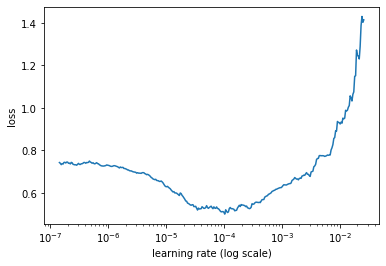

In [11]:
learner.lr_find(show_plot=True, max_epochs=2)

In [12]:
learner.fit_onecycle(8e-6, 4) # 



begin training using onecycle policy with max lr of 8e-06...
Train for 255 steps, validate for 45 steps
Epoch 1/4
255/255 [==============================] - 124s 486ms/step - loss: 0.5414 - accuracy: 0.7203 - val_loss: 0.3805 - val_accuracy: 0.8630
Epoch 2/4
255/255 [==============================] - 121s 476ms/step - loss: 0.2857 - accuracy: 0.8882 - val_loss: 0.2631 - val_accuracy: 0.9000
Epoch 3/4
255/255 [==============================] - 121s 476ms/step - loss: 0.1313 - accuracy: 0.9601 - val_loss: 0.2464 - val_accuracy: 0.9111
Epoch 4/4
255/255 [==============================] - 121s 475ms/step - loss: 0.0641 - accuracy: 0.9850 - val_loss: 0.2640 - val_accuracy: 0.9148


In [13]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

    Negative       0.96      0.89      0.92       149
    Positive       0.87      0.95      0.91       121

    accuracy                           0.91       270
   macro avg       0.91      0.92      0.91       270
weighted avg       0.92      0.91      0.92       270



array([[132,  17],
       [  6, 115]])

In [14]:
learner.view_top_losses(n=1, preproc=t)

----------
id:143 | loss:5.03 | true:Negative | pred:Positive)



In [15]:
print(x_test[143])

عليا النعمه ابدا لا هو ولا الخروف التاني


In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [17]:
predictor.predict('والله حرام والله موتوه لشعب الاردني من وين بدنا نجيب الكو من وين يا الله ارحمو من في الارض يرحمكم من في السماء الله حرام')

'Negative'

In [18]:
predictor.explain('والله حرام والله موتوه لشعب الاردني من وين بدنا نجيب الكو من وين يا الله ارحمو من في الارض يرحمكم من في السماء الله حرام')

In [19]:
predictor.save('ar_teets_predictor')
reloaded_predictor = ktrain.load_predictor('ar_teets_predictor')
reloaded_predictor.predict('الحلو انكم بتحكوا على اساس انو الاردن ما فيه فساد سرقات')

'Negative'

In [20]:
reloaded_predictor.predict_proba('الحلو انكم بتحكوا على اساس انو الاردن ما فيه فساد سرقات')

array([0.98536414, 0.01463585], dtype=float32)

In [21]:
reloaded_predictor.get_classes()

['Negative', 'Positive']